In [8]:
import os
import json
import pandas as pd
import nibabel as nib
from nilearn import datasets, plotting, image, interfaces
from nilearn.plotting import plot_connectome
from nilearn.input_data import NiftiMasker, NiftiMapsMasker
from nilearn.connectome import ConnectivityMeasure
import matplotlib.pyplot as plt
import numpy as np

ModuleNotFoundError: No module named 'pandas'

In [159]:
data_dir = "../data/preprocess"
original_ds_dir = os.path.join(data_dir, "input")
preprocessed_ds_dir = os.path.join(data_dir, "output")

sub_ids_list = [9001]
ses_ids_list = [1, 2]
# Sl_cond: "Sleep randomisation condition. 
# 1 = sleep deprivation before first session, 
# 2 = sleep deprivation before second session"
# sub-9001 is in condition 2

data = {"func":[],
       "confounds":[],
       "phenotypic":""}

# data["func"] contains the paths to the Nifti files (the files containing fMRI data)

for sub_id in sub_ids_list:
    for ses_id in ses_ids_list:
        func_path = os.path.join(preprocessed_ds_dir, f"sub-{sub_id}/ses-{ses_id}/func/sub-{sub_id}_ses-{ses_id}_task-rest_")
        name = "space-MNI152NLin2009cAsym_desc-preproc_bold" # "boldref"
        data["func"].append(func_path + name + ".nii.gz")
        data["confounds"].append(func_path + "desc-confounds_timeseries.tsv")

# TODO: Automatize this by searching in the 'participants.tsv' file
data["sleep"] = ["normal", "deprived"]
        
# Opening JSON file
with open(os.path.join(original_ds_dir, "dataset_description.json")) as file:
    data["description"] = json.load(file)

In [13]:
# Read the dataset documentation
for key in data["description"]:
    print(key+":")
    print(data["description"][key], "\n")

Name:
The Stockholm Sleepy Brain Study: Effects of Sleep Deprivation on Cognitive and Emotional Processing in Young and Old 

BIDSVersion:
1.0.2 

License:
CC0 

Authors:
['Gustav Nilsonne', 'Sandra Tamm', 'Paolo d’Onofrio', 'Hanna Å Thuné', 'Johanna Schwarz', 'Catharina Lavebratt', 'Jia Jia Liu', 'Kristoffer NT Månsson', 'Tina Sundelin', 'John Axelsson', 'Peter Fransson', 'Göran Kecklund', 'Håkan Fischer', 'Mats Lekander', 'Torbjörn Åkerstedt'] 

Acknowledgements:
We are grateful to Diana Cortes and Roberta Nagai for assistance with polysomnography recordings, to Birgitta Mannerstedt Fogelfors for assistance with screening, instructions to participants, and blood sampling, to Rouslan Sitnikov and Jonathan Berrebi for assistance with MRI sequences and auxiliary equipment, to Hannes Ingre for entering sleep diary data into a spreadsheet, and to William Triplett, data curator at openfmri.org, for assistance with data archiving. 

HowToAcknowledge:
We encourage researchers to use the publ

In [30]:
# Load the functional image
fmri_filepath = data['func'][0]
fmri_img = nib.load(fmri_filepath)

In [31]:
print(fmri_img.shape)
print(fmri_img)

(87, 103, 65, 193)
<class 'nibabel.nifti1.Nifti1Image'>
data shape (87, 103, 65, 193)
affine: 
[[   2.25    0.      0.    -96.5 ]
 [   0.      2.25    0.   -132.5 ]
 [   0.      0.      3.    -78.5 ]
 [   0.      0.      0.      1.  ]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  4  87 103  65 193   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int16
bitpix          : 16
slice_start     : 0
pixdim          : [1.   2.25 2.25 3.   2.5  1.   1.   1.  ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 8982.004
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         

/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



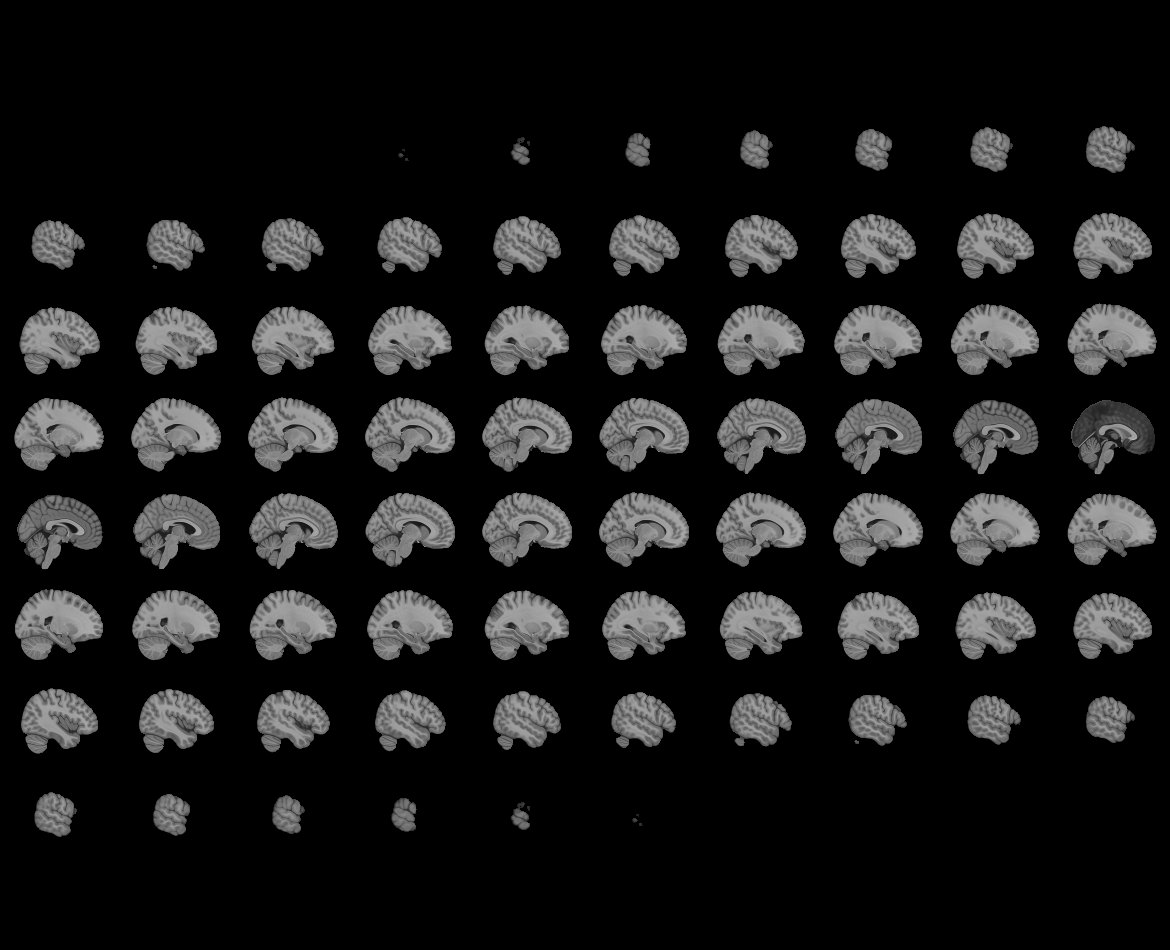
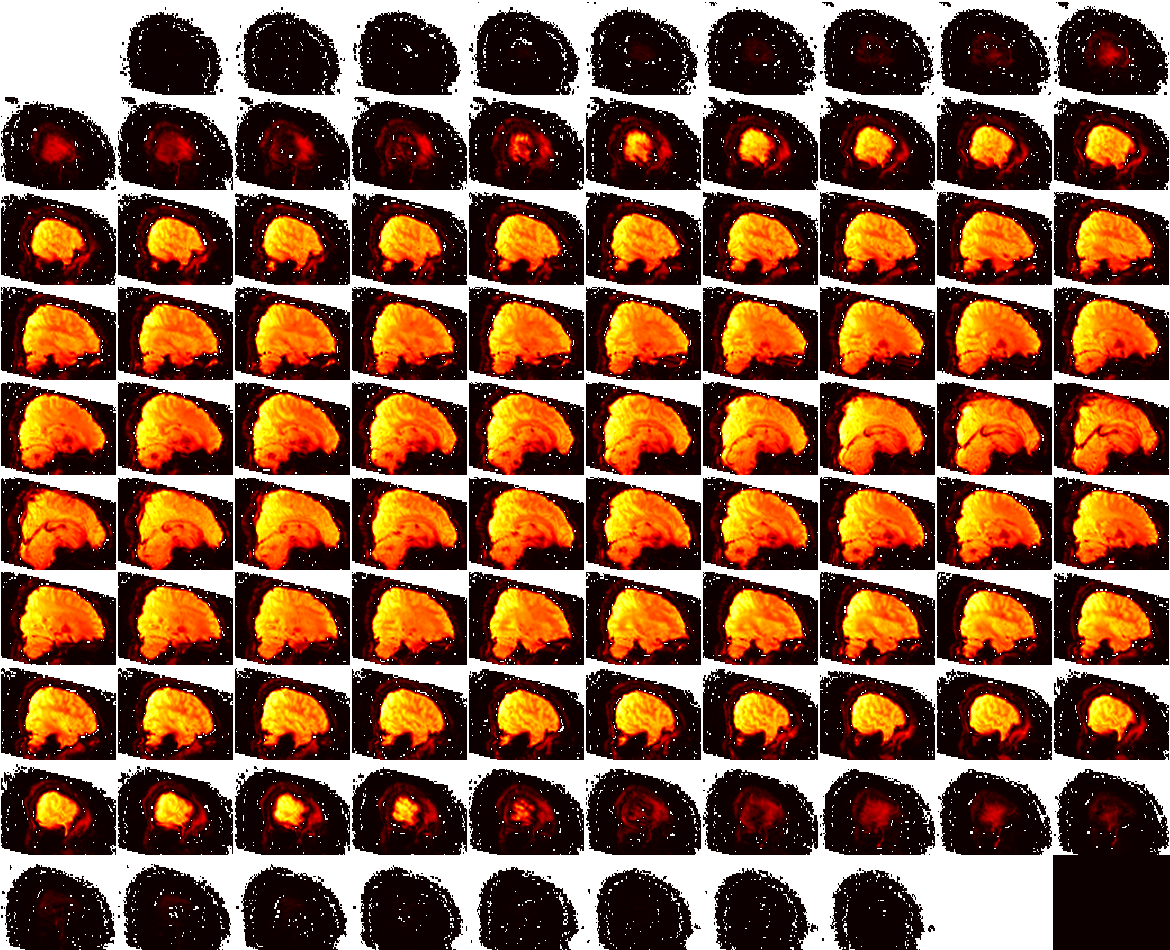

In [32]:
# Take a look at the first time point
plotting.view_img(image.index_img(fmri_img, 2))

/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



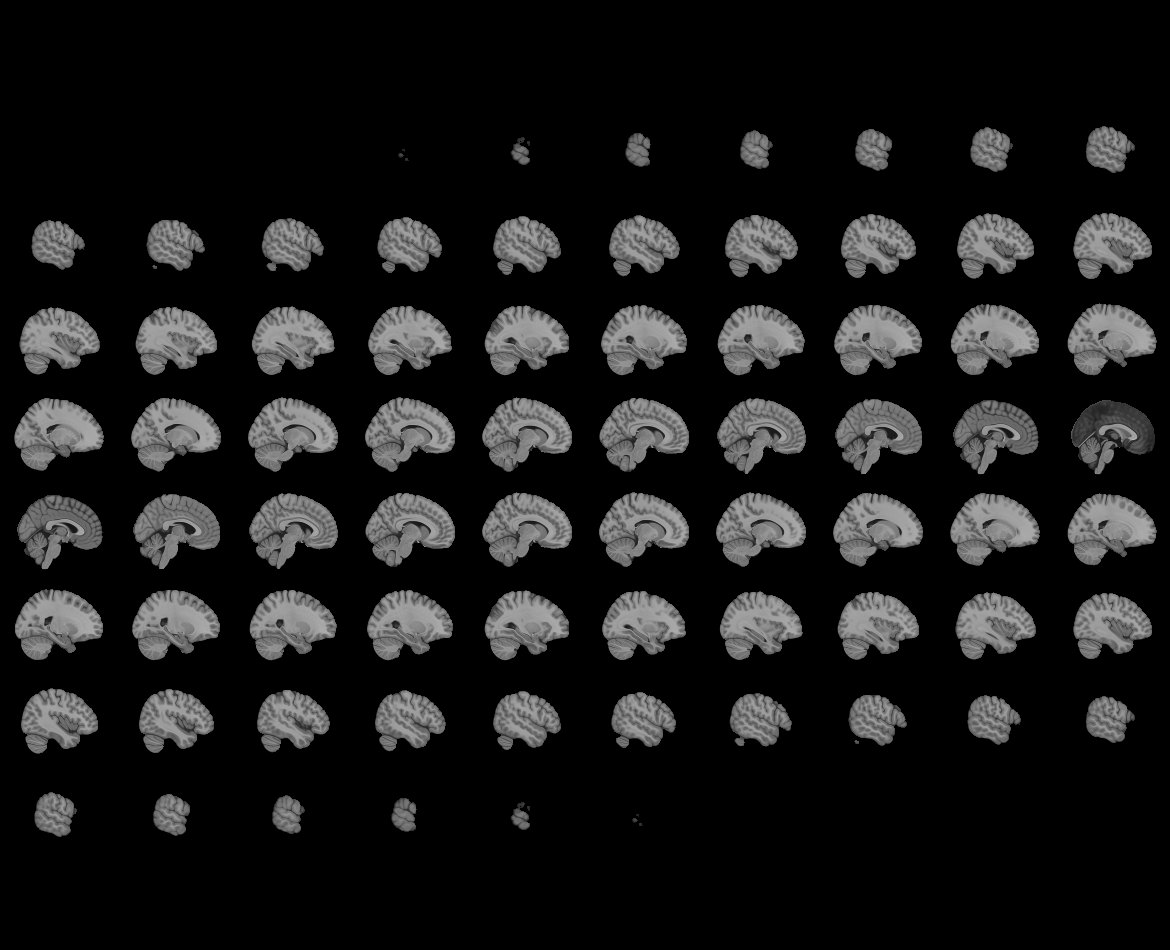
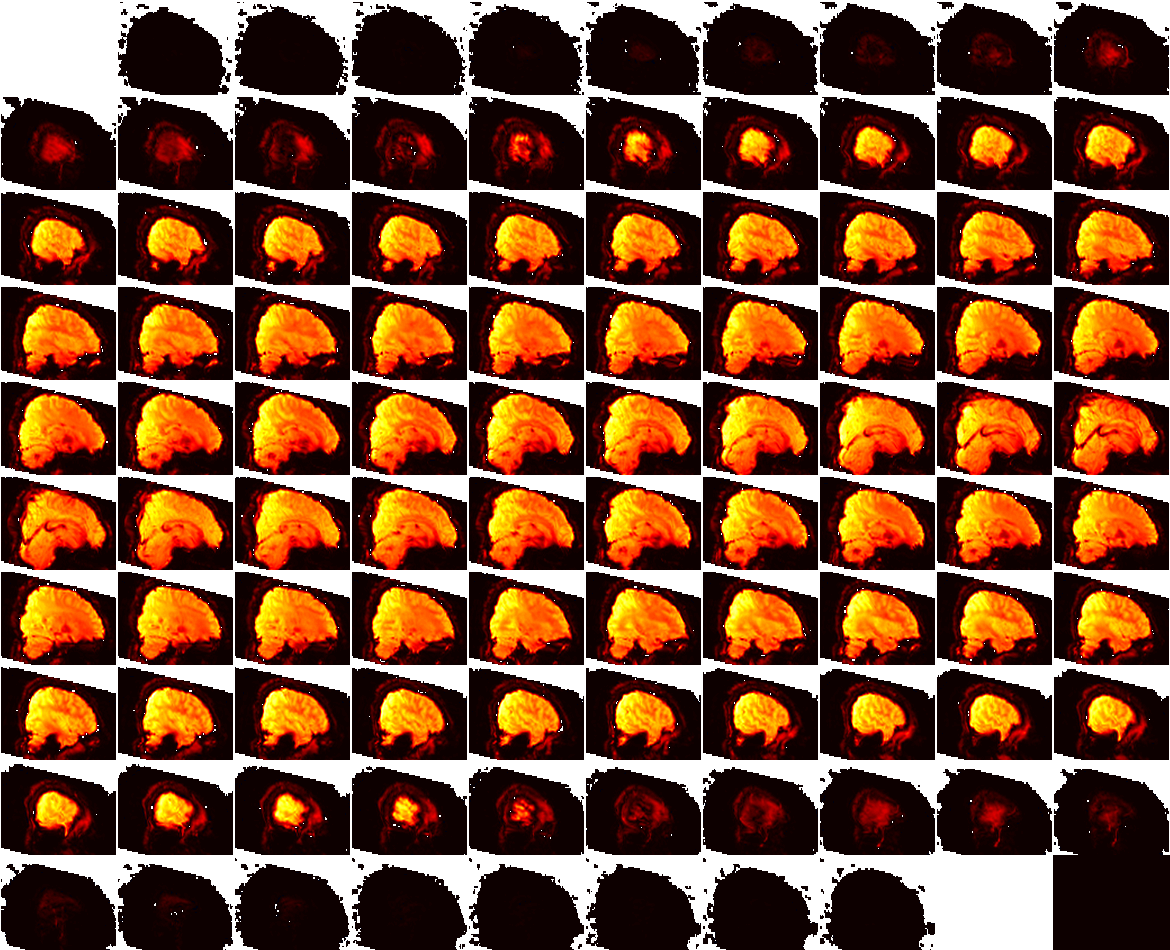

In [80]:
# Take a look at the average
plotting.view_img(image.mean_img(fmri_img))

In [33]:
# let's get the data array 
fmri_data = fmri_img.get_fdata()
fmri_data.shape

(87, 103, 65, 193)

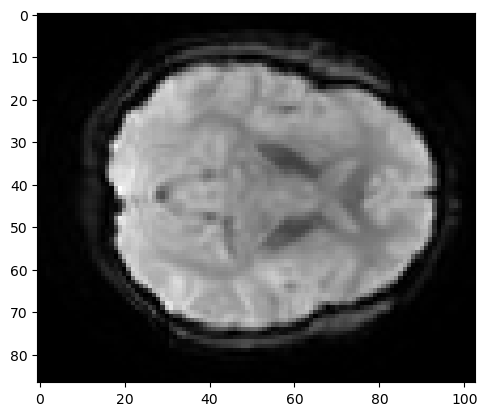

In [34]:
# Plot a (trasnversal) slice of the brain for a time point as an image
plt.imshow(fmri_data[:,:,25,0], cmap='gray')

**Masking the data**

Use a masker to remove the empty background voxels and regress out the confounds.

In [143]:
# Checkout the confounds of the data
confounds = pd.read_csv(data["confounds"][0], sep='\t')
# Remove columns to avoid 'ValueError: array must not contain infs or NaNs'
confounds = confounds.replace([-np.inf, np.inf, 0], np.nan)
# confounds = confounds.replace([-np.inf, np.inf, np.nan], 0)
confounds = confounds.dropna(axis=1)

In [144]:
confounds.head()

global_signal  global_signal_power2          csf    csf_power2  \
0    4857.413874          2.359447e+07  5031.915167  2.532017e+07   
1    4862.142918          2.364043e+07  5013.925877  2.513945e+07   
2    4873.266870          2.374873e+07  5034.408889  2.534527e+07   
3    4878.065886          2.379553e+07  5035.187768  2.535312e+07   
4    4874.910978          2.376476e+07  5023.989531  2.524047e+07   

   white_matter  white_matter_power2       csf_wm     tcompcor  t_comp_cor_00  \
0   4479.346245         2.006454e+07  4524.076183  3683.116304      -0.045177   
1   4476.093993         2.003542e+07  4519.474220  3702.416324       0.027135   
2   4480.052352         2.007087e+07  4525.394803  3766.545219       0.114970   
3   4485.893872         2.012324e+07  4530.146066  3769.511800       0.011159   
4   4485.894556         2.012325e+07  4528.991815  3776.344661       0.001292   

   t_comp_cor_01  ...   trans_x  trans_x_power2   trans_y  trans_y_power2  \
0       0.099209  ... -0.044425        0.001974 -0.000121    1.463108e-08   
1       0.064874  ... -0.037741        0.001424  0.016161    2.611618e-04   
2       0.097994  ... -0.033539        0.001125  0.038045    1.447384e-03   
3       0.218456  ... -0.019090        0.000364  0.028405    8.068497e-04   
4       0.203529  ... -0.026411        0.000698  0.036962    1.366152e-03   

    trans_z  trans_z_power2     rot_x  rot_x_power2     rot_y  rot_y_power2  
0 -0.134478        0.018084  0.000759  5.768342e-07 -0.000377  1.418117e-07  
1 -0.130135        0.016935  0.000858  7.360061e-07 -0.000412  1.693594e-07  
2 -0.139699        0.019516  0.001198  1.434653e-06 -0.000412  1.693594e-07  
3 -0.122629        0.015038  0.001044  1.090771e-06 -0.000320  1.021109e-07  
4 -0.122074        0.014902  0.001077  1.161006e-06 -0.000412  1.693594e-07  

[5 rows x 188 columns]

In [153]:
confounds, sample_mask = interfaces.fmriprep.load_confounds(data["func"][0])

In [154]:
confounds.head()

cosine00  cosine01  cosine02  cosine03  cosine04  cosine05        csf  \
0  0.101794  0.101784  0.101767  0.101743  0.101713  0.101676  24.296340   
1  0.101767  0.101676  0.101524  0.101312  0.101040  0.100707   6.307049   
2  0.101713  0.101460  0.101040  0.100452  0.099697  0.098778  26.790061   
3  0.101632  0.101137  0.100314  0.099165  0.097695  0.095908  27.568941   
4  0.101524  0.100707  0.099349  0.097459  0.095046  0.092123  16.370703   

      rot_x  rot_x_derivative1  rot_x_derivative1_power2  ...  trans_x_power2  \
0 -0.000317           0.000091             -4.404364e-08  ...        0.000846   
1 -0.000218           0.000091             -4.404364e-08  ...        0.000297   
2  0.000122           0.000332              6.177762e-08  ...       -0.000003   
3 -0.000032          -0.000161             -3.020620e-08  ...       -0.000763   
4  0.000001           0.000026             -5.263295e-08  ...       -0.000430   

    trans_y  trans_y_derivative1  trans_y_derivative1_power2  trans_y_power2  \
0 -0.077004             0.015443                    0.000158       -0.007917   
1 -0.060723             0.015443                    0.000158       -0.007656   
2 -0.038839             0.021045                    0.000371       -0.006470   
3 -0.048478            -0.010478                   -0.000015       -0.007110   
4 -0.039922             0.007717                   -0.000034       -0.006551   

    trans_z  trans_z_derivative1  trans_z_derivative1_power2  trans_z_power2  \
0 -0.096495             0.004080                   -0.000330        0.015388   
1 -0.092152             0.004080                   -0.000330        0.014239   
2 -0.101716            -0.009827                   -0.000257        0.016820   
3 -0.084646             0.016807                   -0.000057        0.012342   
4 -0.084091             0.000292                   -0.000348        0.012206   

   white_matter  
0     17.238756  
1     13.986504  
2     17.944863  
3     23.786383  
4     23.787067  

[5 rows x 32 columns]

In [155]:
masker = NiftiMasker()
masked_data = masker.fit_transform(fmri_filepath, sample_mask=sample_mask)#confounds=confounds)
print(masked_data.shape)

(193, 582381)


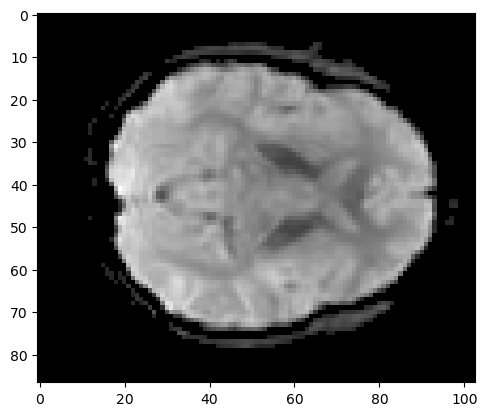

In [156]:
thresholded_masked_data = masked_data * (masked_data > masked_data.mean())

thresholded_img = masker.inverse_transform(thresholded_masked_data)

plt.imshow(thresholded_img.get_fdata()[:,:,25,0], cmap='gray')

/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/opt/conda/lib/python3.10/site-packages/nilearn/plotting/html_document.py:59: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  warnings.warn('It seems you have created more than {} '



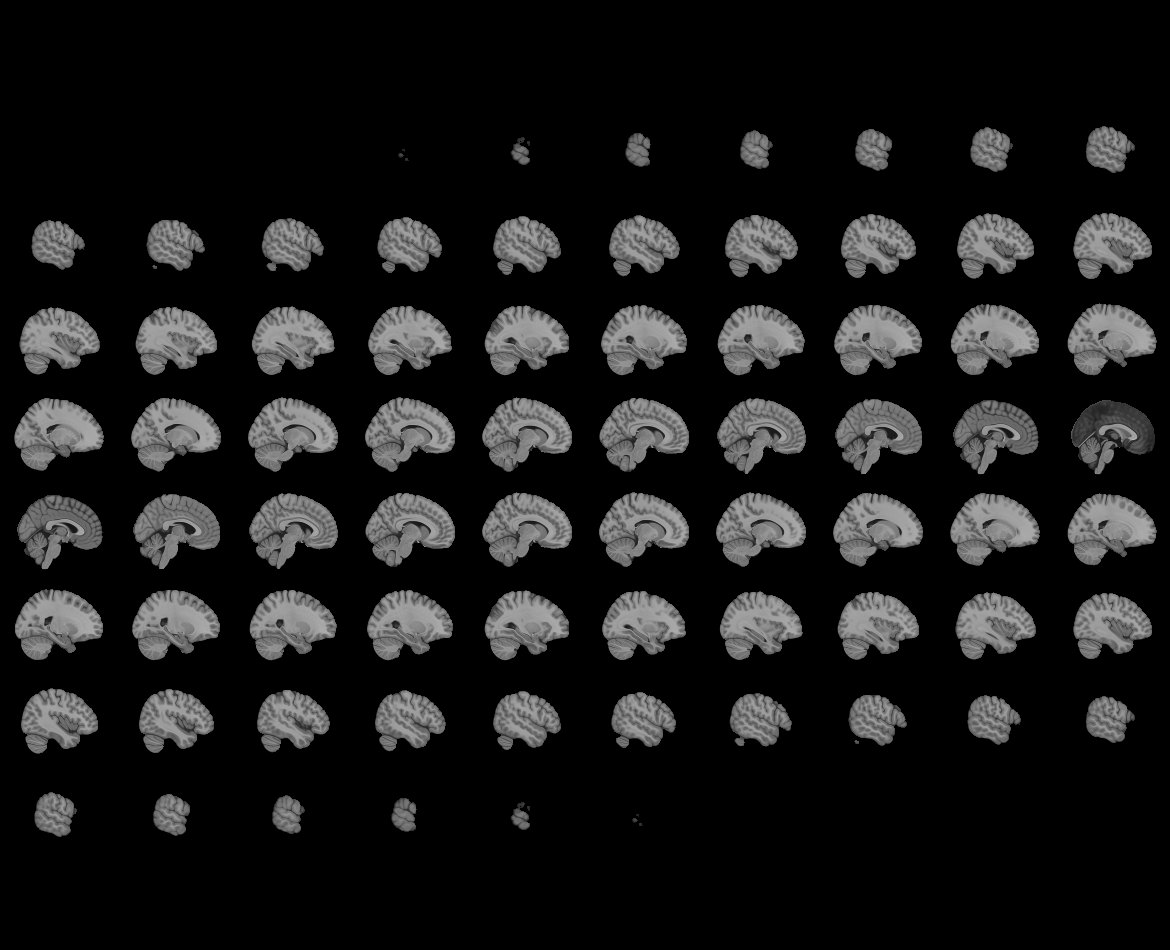
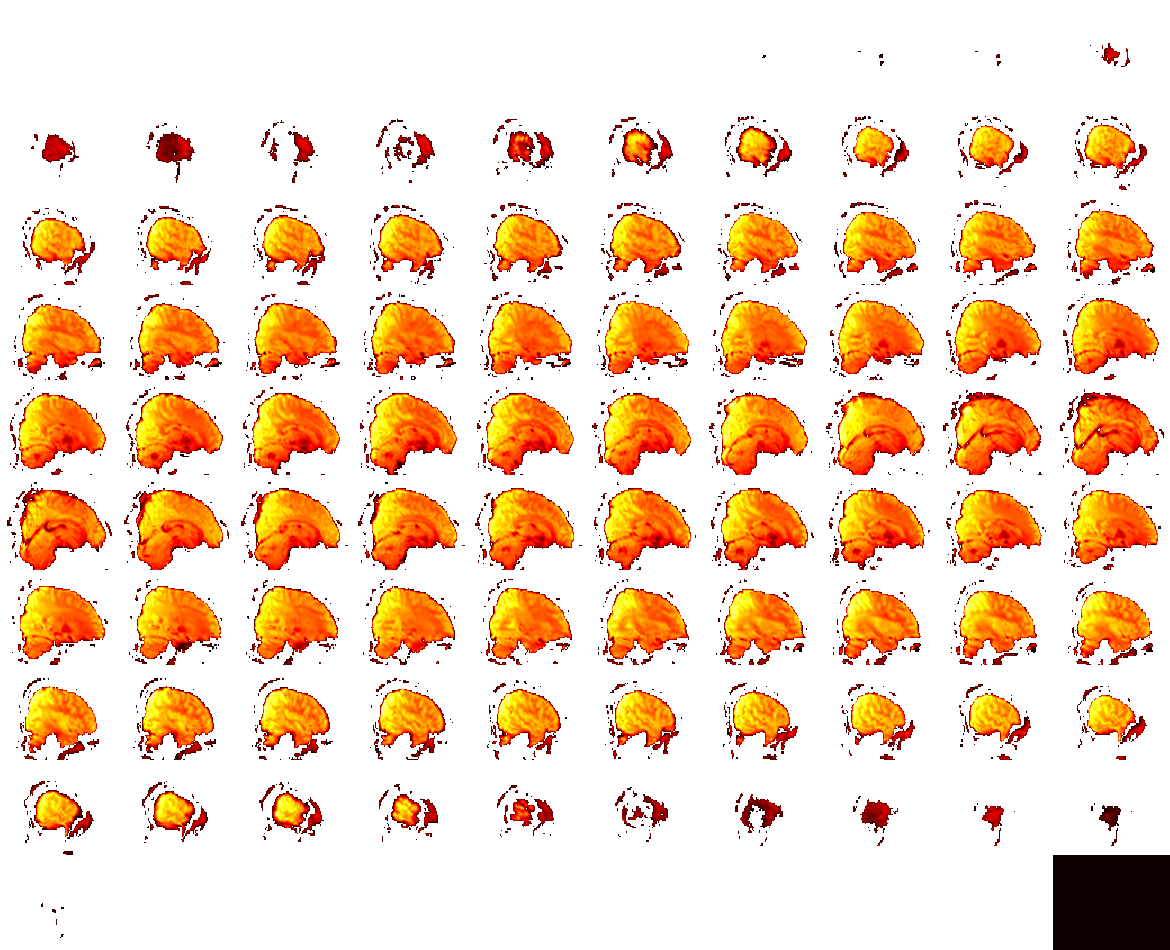

In [149]:
plotting.view_img(image.mean_img(thresholded_img))

**Using an atlas**

Use an atlas that defines region of interest (ROIs) to cluster the voxels to reduce the size of the connectome to compute and analyze.

In [150]:
atlas_dataset = datasets.fetch_atlas_msdl(data_dir=data_dir)
atlas_filepath = atlas_dataset.maps
labels = atlas_dataset.labels

In [101]:
atlas_masker = NiftiMapsMasker(maps_img=atlas_filepath, standardize=True)

data_in_atlas = atlas_masker.fit_transform(fmri_filepath, confounds=confounds)
data_in_atlas.shape

/opt/conda/lib/python3.10/site-packages/joblib/memory.py:349: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  return self.func(*args, **kwargs)


(193, 39)

**Connectome**

Compute and plot a correlation matrix.

/opt/conda/lib/python3.10/site-packages/nilearn/connectome/connectivity_matrices.py:495: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  covariances_std = [


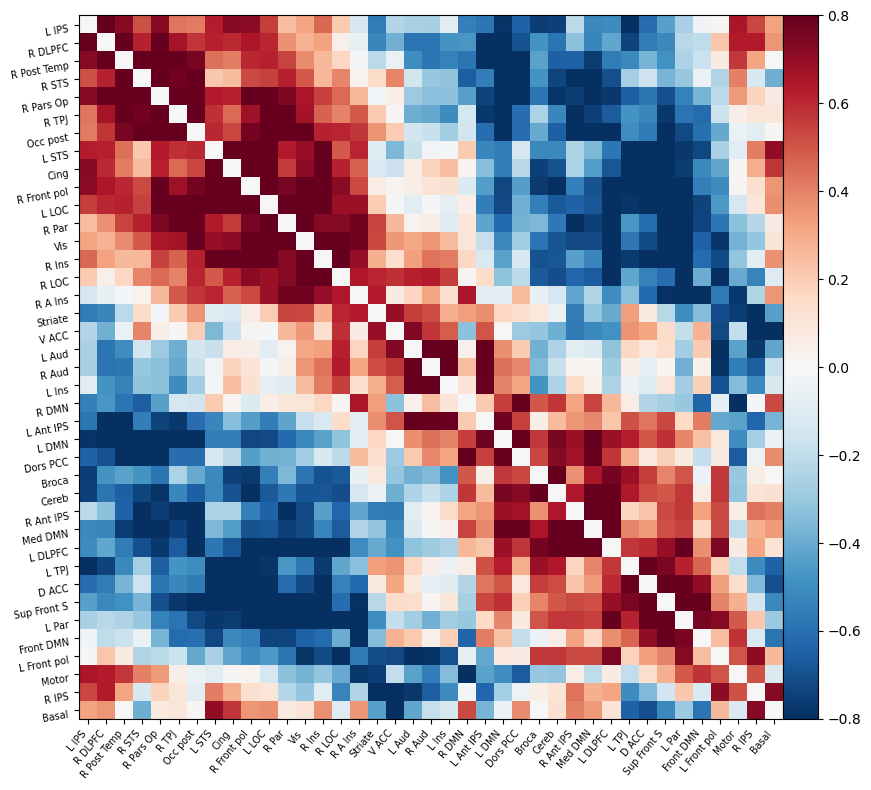

In [151]:
correlation_measure = ConnectivityMeasure(kind='correlation')
correlation_matrix = correlation_measure.fit_transform([data_in_atlas])[0]

# Plot the correlation matrix
# Mask the main diagonal for visualization:
np.fill_diagonal(correlation_matrix, 0)
# The matrix is reordered for block-like representation
plotting.plot_matrix(correlation_matrix, figure=(10, 8), labels=labels,
                     vmax=0.8, vmin=-0.8, reorder=True)

/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/opt/conda/lib/python3.10/site-packages/nilearn/plotting/html_document.py:59: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  warnings.warn('It seems you have created more than {} '



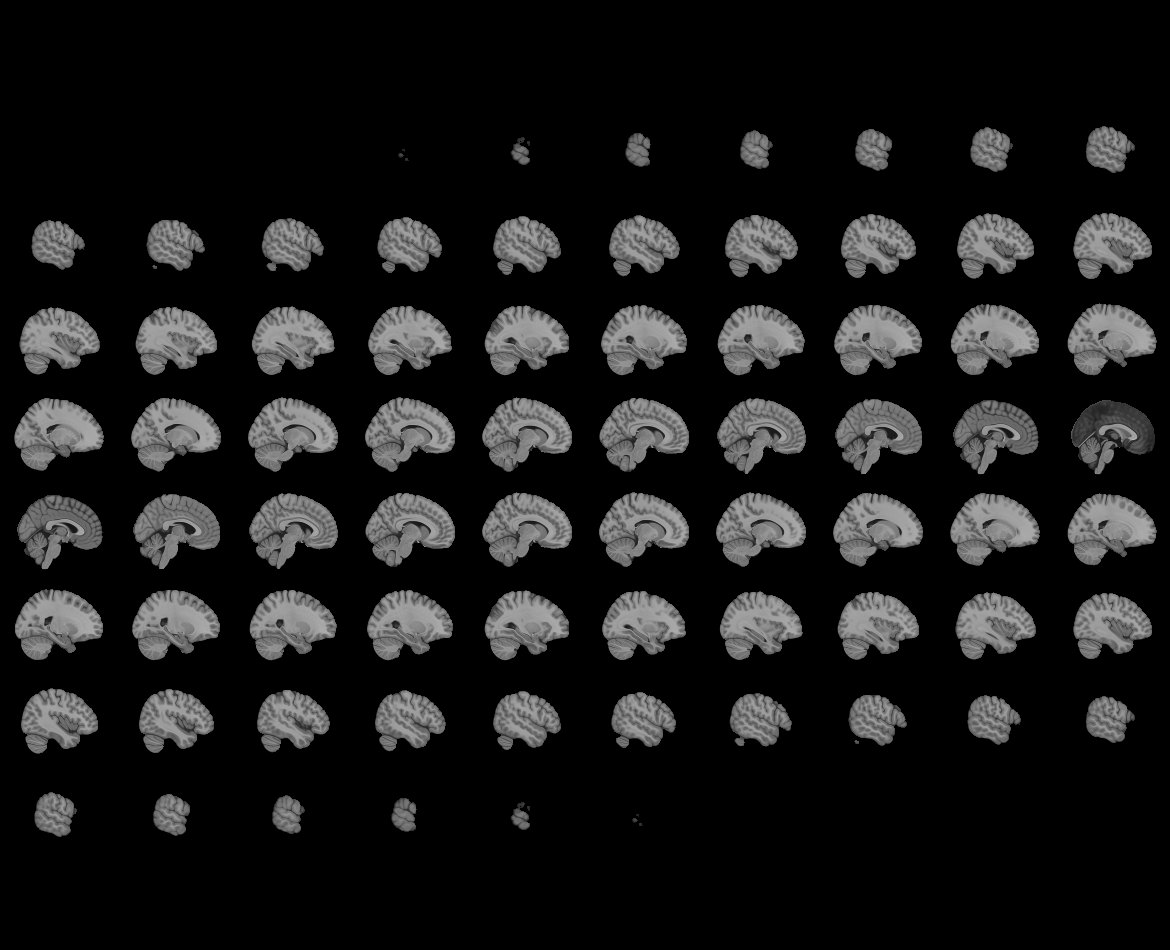
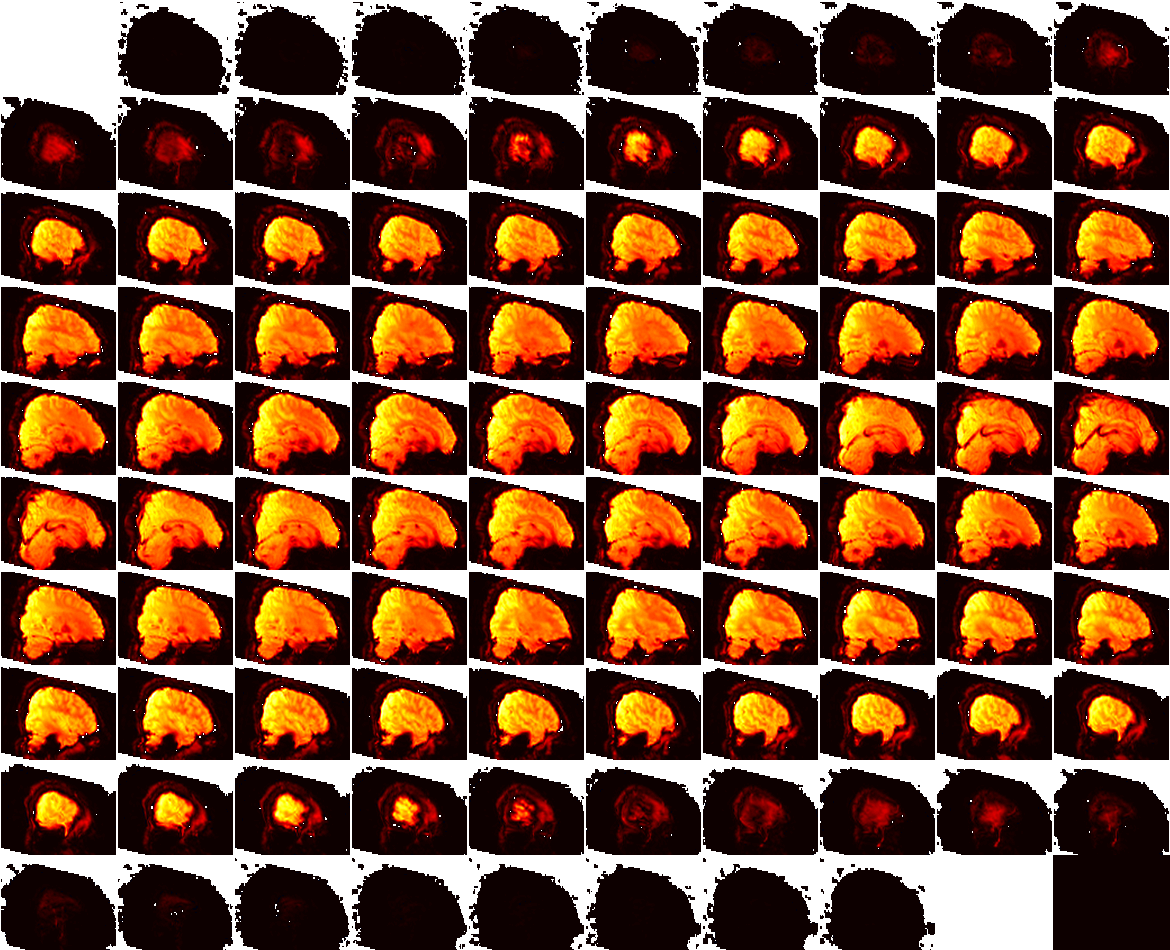

In [113]:
# Average the volumes on the time axis to generate a 3D NiftiImage
fmri_img_mean = image.mean_img(fmri_img)
plotting.view_img(fmri_img_mean)

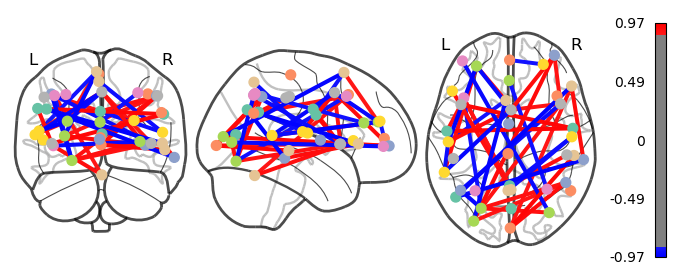

In [117]:
coords = atlas_dataset.region_coords

# Threshold to keep only the 5% (10%) of edges with the highest value
# because the graph is very dense
plot_connectome(correlation_matrix, coords,
                edge_threshold="95%", colorbar=True)

# Run for the two sessions

In [ ]:
# Using an atlas
atlas_dataset = datasets.fetch_atlas_msdl(data_dir=data_dir)
atlas_filepath = atlas_dataset.maps
labels = atlas_dataset.labels
atlas_masker = NiftiMapsMasker(maps_img=atlas_filepath, standardize=True)

ses_id: 1
sleep: normal
masked_data shape: (193, 582381)


/opt/conda/lib/python3.10/site-packages/joblib/memory.py:349: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  return self.func(*args, **kwargs)
/opt/conda/lib/python3.10/site-packages/nilearn/connectome/connectivity_matrices.py:495: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  covariances_std = [


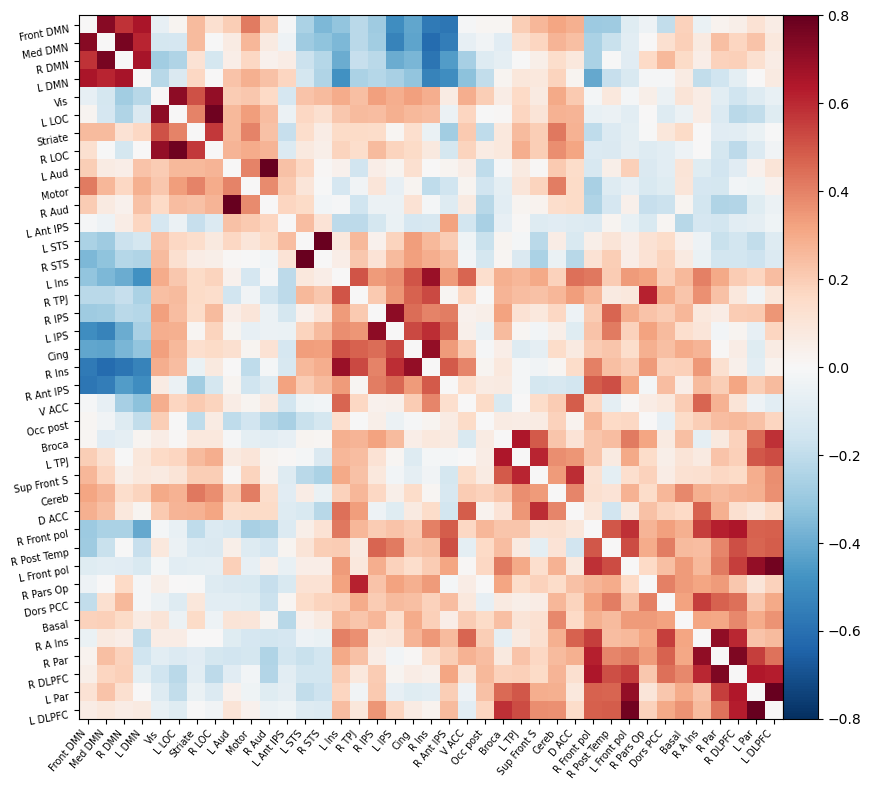

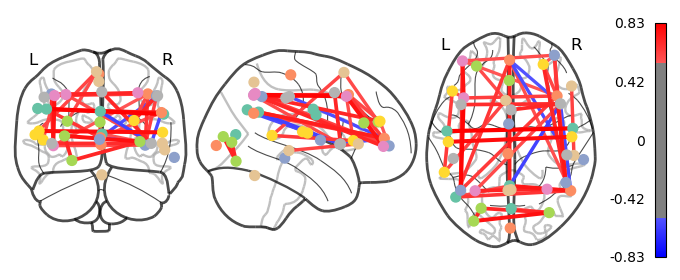

In [160]:
i = 0
ses_id = i+1
print("ses_id:", ses_id)
print("sleep:", data["sleep"][i])
# Load the functional image
fmri_filepath = data['func'][i]
fmri_img = nib.load(fmri_filepath)

# Mask the data
confounds, sample_mask = interfaces.fmriprep.load_confounds(fmri_filepath)
masker = NiftiMasker()
masked_data = masker.fit_transform(fmri_filepath, sample_mask=sample_mask)#confounds=confounds)
print("masked_data shape:", masked_data.shape)

thresholded_masked_data = masked_data * (masked_data > masked_data.mean())

thresholded_img = masker.inverse_transform(thresholded_masked_data)

#     plt.imshow(thresholded_img.get_fdata()[:,:,25,0], cmap='gray')
#     plt.show()

data_in_atlas = atlas_masker.fit_transform(fmri_filepath, confounds=confounds)

correlation_measure = ConnectivityMeasure(kind='correlation')
correlation_matrix = correlation_measure.fit_transform([data_in_atlas])[0]

# Plot the correlation matrix
# Mask the main diagonal for visualization:
np.fill_diagonal(correlation_matrix, 0)
# The matrix is reordered for block-like representation
plotting.plot_matrix(correlation_matrix, figure=(10, 8), labels=labels,
                     vmax=0.8, vmin=-0.8, reorder=True)

coords = atlas_dataset.region_coords

# Threshold to keep only the 5% (10%) of edges with the highest value
# because the graph is very dense
plot_connectome(correlation_matrix, coords,
                edge_threshold="95%", colorbar=True)

ses_id: 2
['normal', 'deprived']
masked_data shape: (196, 582400)


/opt/conda/lib/python3.10/site-packages/joblib/memory.py:349: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  return self.func(*args, **kwargs)
/opt/conda/lib/python3.10/site-packages/nilearn/connectome/connectivity_matrices.py:495: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  covariances_std = [


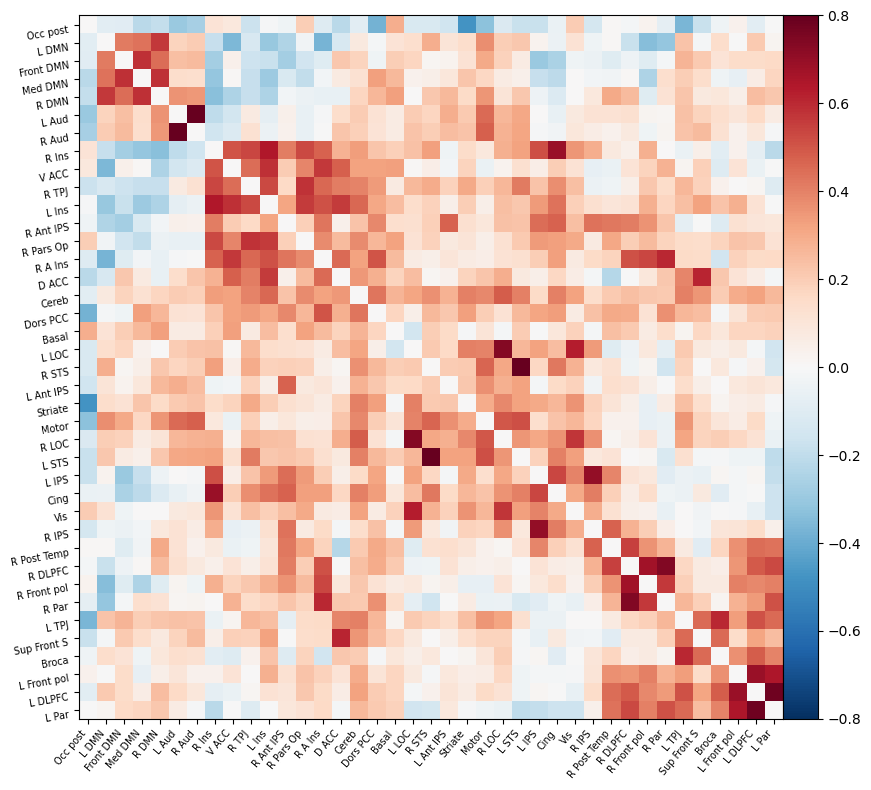

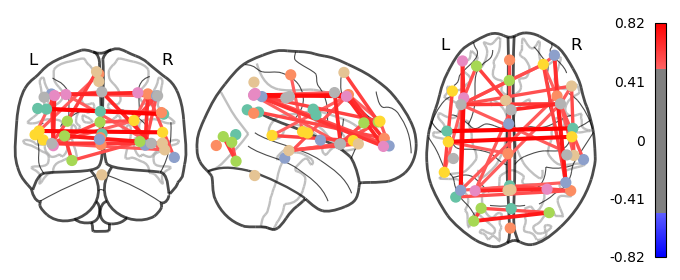

In [161]:
i = 1
ses_id = i+1
print("ses_id:", ses_id)
print(data["sleep"][i])
# Load the functional image
fmri_filepath = data['func'][i]
fmri_img = nib.load(fmri_filepath)

# Mask the data
confounds, sample_mask = interfaces.fmriprep.load_confounds(fmri_filepath)
masker = NiftiMasker()
masked_data = masker.fit_transform(fmri_filepath, sample_mask=sample_mask)#confounds=confounds)
print("masked_data shape:", masked_data.shape)

thresholded_masked_data = masked_data * (masked_data > masked_data.mean())

thresholded_img = masker.inverse_transform(thresholded_masked_data)

#     plt.imshow(thresholded_img.get_fdata()[:,:,25,0], cmap='gray')
#     plt.show()

data_in_atlas = atlas_masker.fit_transform(fmri_filepath, confounds=confounds)

correlation_measure = ConnectivityMeasure(kind='correlation')
correlation_matrix = correlation_measure.fit_transform([data_in_atlas])[0]

# Plot the correlation matrix
# Mask the main diagonal for visualization:
np.fill_diagonal(correlation_matrix, 0)
# The matrix is reordered for block-like representation
plotting.plot_matrix(correlation_matrix, figure=(10, 8), labels=labels,
                     vmax=0.8, vmin=-0.8, reorder=True)

coords = atlas_dataset.region_coords

# Threshold to keep only the 5% (10%) of edges with the highest value
# because the graph is very dense
plot_connectome(correlation_matrix, coords,
                edge_threshold="95%", colorbar=True)

ses_id: 1
masked_data shape: (193, 582381)


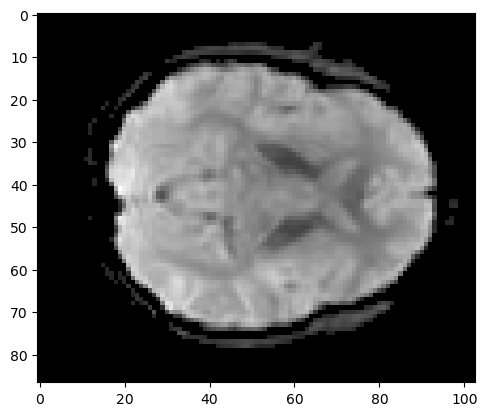

/opt/conda/lib/python3.10/site-packages/joblib/memory.py:349: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  return self.func(*args, **kwargs)
/opt/conda/lib/python3.10/site-packages/nilearn/connectome/connectivity_matrices.py:495: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  covariances_std = [


ses_id: 2
masked_data shape: (196, 582400)


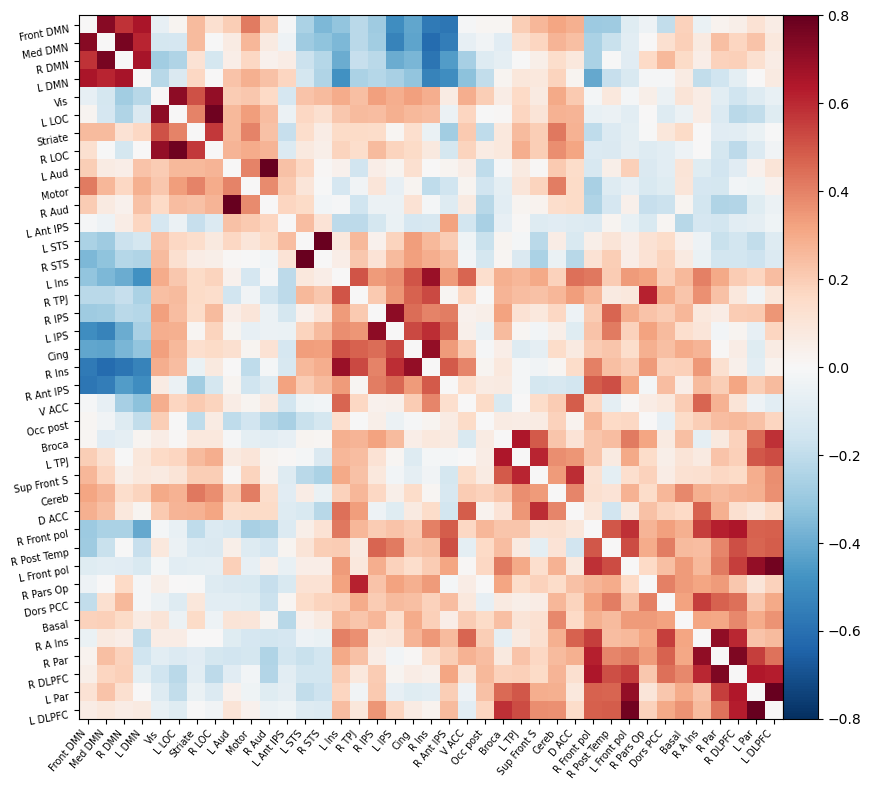

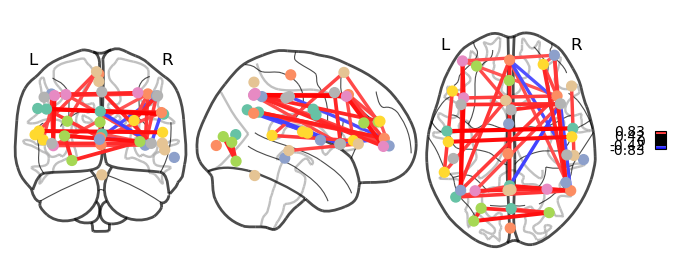

/opt/conda/lib/python3.10/site-packages/joblib/memory.py:349: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  return self.func(*args, **kwargs)
/opt/conda/lib/python3.10/site-packages/nilearn/connectome/connectivity_matrices.py:495: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  covariances_std = [


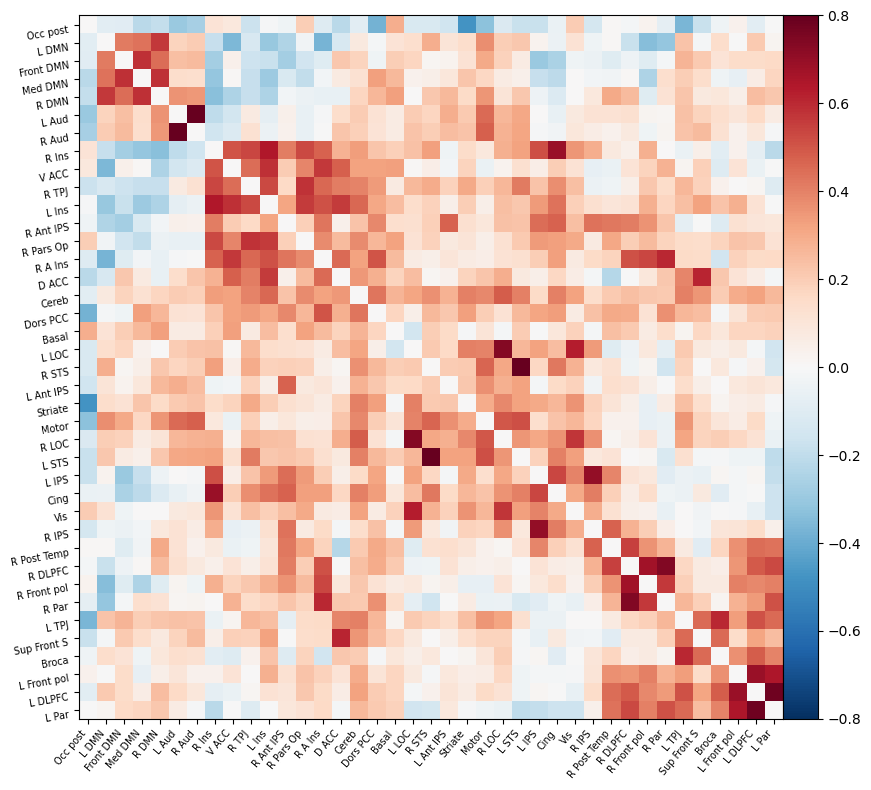

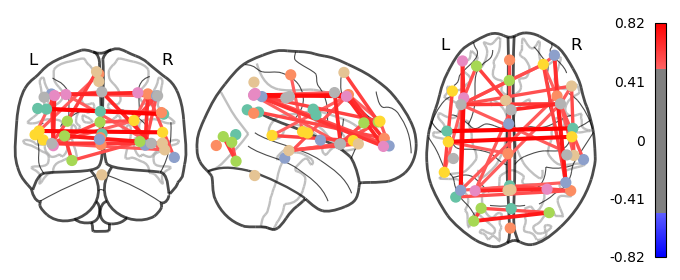

In [157]:
# Using an atlas
atlas_dataset = datasets.fetch_atlas_msdl(data_dir=data_dir)
atlas_filepath = atlas_dataset.maps
labels = atlas_dataset.labels
atlas_masker = NiftiMapsMasker(maps_img=atlas_filepath, standardize=True)

i = 0
    ses_id = i+1
    print("ses_id:", ses_id)
    print("sleep:", data["sleep"][i])
    # Load the functional image
    fmri_filepath = data['func'][i]
    fmri_img = nib.load(fmri_filepath)
    
    # Mask the data
    confounds, sample_mask = interfaces.fmriprep.load_confounds(fmri_filepath)
    masker = NiftiMasker()
    masked_data = masker.fit_transform(fmri_filepath, sample_mask=sample_mask)#confounds=confounds)
    print("masked_data shape:", masked_data.shape)
    
    thresholded_masked_data = masked_data * (masked_data > masked_data.mean())

    thresholded_img = masker.inverse_transform(thresholded_masked_data)

    plt.imshow(thresholded_img.get_fdata()[:,:,25,0], cmap='gray')
    plt.show()
    
    data_in_atlas = atlas_masker.fit_transform(fmri_filepath, confounds=confounds)

    correlation_measure = ConnectivityMeasure(kind='correlation')
    correlation_matrix = correlation_measure.fit_transform([data_in_atlas])[0]

    # Plot the correlation matrix
    # Mask the main diagonal for visualization:
    np.fill_diagonal(correlation_matrix, 0)
    # The matrix is reordered for block-like representation
    plotting.plot_matrix(correlation_matrix, figure=(10, 8), labels=labels,
                         vmax=0.8, vmin=-0.8, reorder=True)
    
    coords = atlas_dataset.region_coords

    # Threshold to keep only the 5% (10%) of edges with the highest value
    # because the graph is very dense
    plot_connectome(correlation_matrix, coords,
                    edge_threshold="95%", colorbar=True)
    plt.show()